In [1]:

import brainscore_vision
import torch
import numpy as np

# Imports
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
from recognition_parametrised_model import RPM

from matplotlib import pyplot as plt
from save_load import load_crpm, save_crpm

import torch
import torch.nn.functional as F



neural_data = brainscore_vision.load_dataset("MajajHong2015.public")
#neural_data = neural_data.transpose('presentation', 'neuroid', 'time_bin')
#neural_data



# Compact data
compact_data = neural_data.multi_groupby(['category_name', 'object_name', 'stimulus_id', 'variation']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='IT')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)

# All Images
stimulus_set = neural_data.attrs['stimulus_set']

# Neural Recordings
neural_observation = compact_data.data

# Stimulus labels
label_basic, basic_index = np.unique(compact_data['category_name'].data, return_inverse=True)
label_categories, categories_index = np.unique(compact_data['object_name'].data, return_inverse=True)

# Level of difficulty/variation for each images
variation = compact_data['variation'].data

# Find trials with given level of difficulty
#select_variation = np.where(variation >= 0)[0]
select_variation = np.where(variation == 3)[0]
select_variation = np.where(variation == 0)[0]

# Filter the dataset Using the trials with given level of difficulty
filtered_neural = np.array(neural_observation[select_variation])
filtered_latent_basic = basic_index[select_variation]
filtered_latent_categories = categories_index[select_variation]

#%%

# Combined Train and Test set sizes
num_observations_tot = len(filtered_neural)
assert num_observations_tot == len(filtered_latent_basic)
assert num_observations_tot == len(filtered_latent_categories)

# Gather images
images_height = 256
images_width = 256

# Gather Images
filtered_images = torch.zeros(num_observations_tot, images_height, images_width)
for ii in range(num_observations_tot):
    path_cur = compact_data['stimulus_id'].data[select_variation][ii]
    path_cur = stimulus_set.get_stimulus(path_cur)
    ima_cur = image.imread(path_cur)[:, :, 0]
    filtered_images[ii] = torch.tensor(ima_cur)

# Downsample images
ds_factor = 0.5
filtered_images = torch.nn.functional.interpolate(filtered_images.unsqueeze(dim=1), scale_factor=ds_factor, mode='bilinear')
filtered_images = filtered_images.squeeze(dim=1)

#%%

filtered_images = filtered_images[:, 20:110][:, :, 20:110]
#%%


/nfs/ghome/live/hugos/anaconda3/lib/python3.7/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


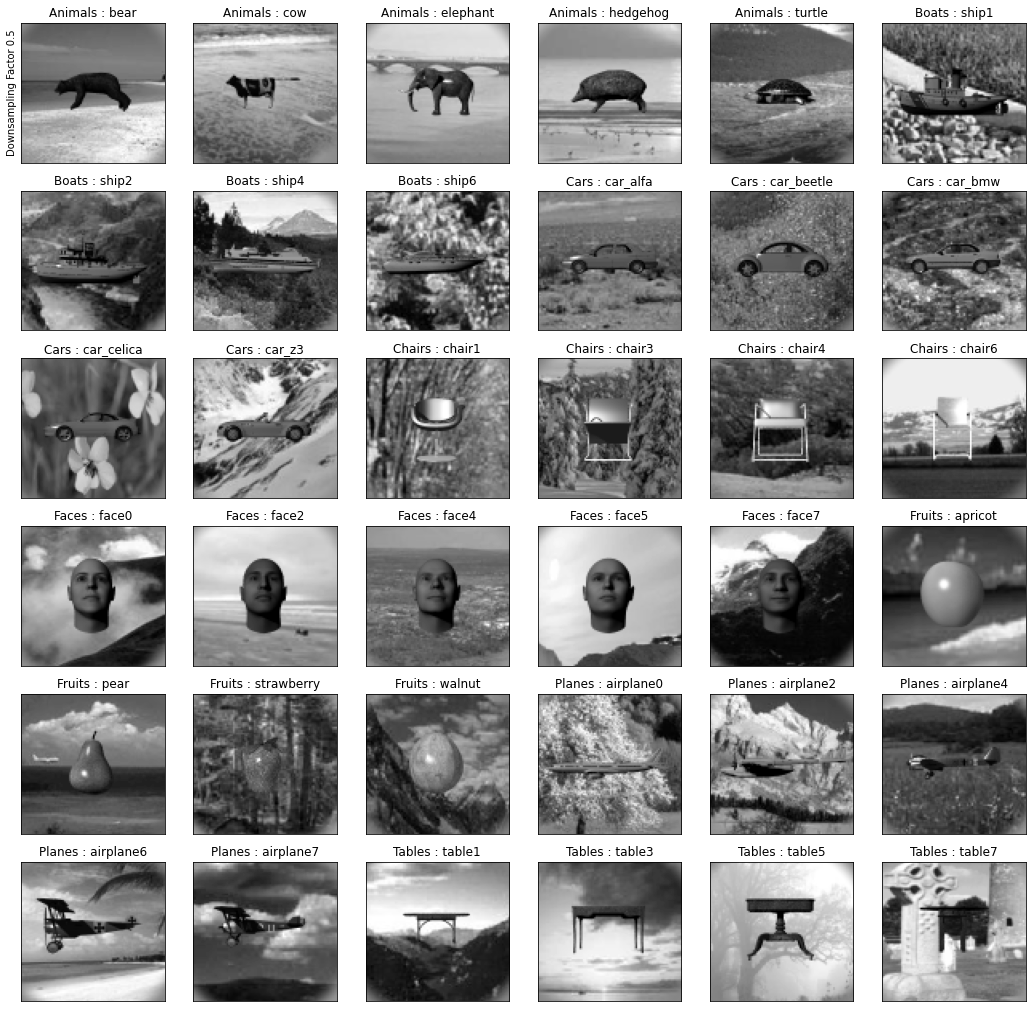

In [2]:

#%% Plot
do_plot = True
if do_plot:
    num_plot = 35
    plot_check = np.arange(0, num_observations_tot, int(num_observations_tot / num_plot))

    figh = int(np.ceil(np.sqrt(len(plot_check))))
    figw = int(np.ceil(np.sqrt(len(plot_check))))

    plt.figure(figsize=(3 * figw, 3 * figh))
    for ii, id in enumerate(plot_check):
        plt.subplot(figh, figw, ii + 1)
        lab_basic = label_basic[filtered_latent_basic[id]]
        lab_categories = label_categories[filtered_latent_categories[id]]

        plt.imshow(filtered_images[id], cmap='gray', aspect='auto')
        plt.title(lab_basic + ' : ' + lab_categories)
        plt.xticks([])
        plt.yticks([])

        if ii == 0:
            plt.ylabel('Downsampling Factor ' + str(ds_factor))



In [3]:
#%%

#%% Builds

# Build Observations
observations1 = filtered_images
observations2 = torch.tensor(filtered_neural)

# Random train /test split
train_test_perm = torch.randperm(num_observations_tot)
train_length = int(num_observations_tot/2)
train_indices = train_test_perm[:train_length]
tests_indices = train_test_perm[train_length:]

observations1_train = observations1[train_indices]
observations2_train = observations2[train_indices]
observations1_tests = observations1[tests_indices]
observations2_tests = observations2[tests_indices]

true_latent_train = filtered_latent_basic[train_indices]
true_latent_tests = filtered_latent_basic[tests_indices]

# GPUs ?
dtype = torch.float32
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Gather and move obs
observations_train = (observations1_train.to(device).unsqueeze(1), observations2_train.to(device).unsqueeze(1))
observations_tests = (observations1_tests.to(device).unsqueeze(1), observations2_tests.to(device).unsqueeze(1))


#%%


cuda


In [4]:
# Shuffle pairs and use multi/uni-modal input
do_shuffle = True

if do_shuffle:
    
    # Select What Type of factors to use [0: images, 1: neural]
    factors = [0, 1]
    
    # Number of pairs
    num_observations_shuffled = 400

    # All indices of the current dataset
    all_classes = np.unique(true_latent_train)
    num_classes = len(all_classes)
    
    # Random list of true latent indices
    shuffled_classes = all_classes[torch.round((num_classes-1) * torch.rand(num_observations_shuffled)).numpy().astype(int)]
    
    # Init Training Observations
    observations_shuffled = [torch.zeros(num_observations_shuffled, *observations_train[ii].shape[1:]) for ii in factors]
    
    # Randomly assign each observation
    for ii in range(num_observations_shuffled):
        
        # Sample observations
        mask = np.where(shuffled_classes[ii] == true_latent_train)[0]
        observation_indices = torch.randperm(len(mask))[:len(factors)]
        
        # Assign it to each factors
        for jj in range(len(factors)):
            observations_shuffled[jj][ii] = observations_train[factors[jj]][mask[observation_indices[jj]]]

    # Move and Copy (if necessary, for the test set) observaions
    observations_train = [ii.to(device) for ii in observations_shuffled]
    observations_tests = [observations_tests[ii].to(device) for ii in factors]
    
    true_latent_train = torch.tensor(shuffled_classes)
    true_latent_tests = torch.tensor(true_latent_tests)


observations_train = [ii for ii in observations_train]
observations_tests = [ii for ii in observations_tests]



In [15]:



from recognition_parametrised_model import RPM
import torch.nn.functional as F

dim_latent = 2


prior_params = {
    'gp_kernel': 'RBF',
    'optimizer': {'name': 'RMSprop', 'param': {'lr': 0.0e-3}}
}

factors_params = {
    'channels': [[1, 20, 20], []],
    'kernel_conv': [[2, 2], []],
    'kernel_pool': [[1, 1], []],
    'dim_hidden': [[10, 10], []],
    'non_linearity': [F.relu, torch.nn.Identity()],
    'covariance': ['fixed', 'fixed'],
    'optimizer': {'name': 'RMSprop', 'param': {'lr': 0.5e-3}},
    'dropout':0.0,
}

auxiliary_params = {
    'channels': [[1, 20, 20], []],
    'kernel_conv': [[2, 2], []],
    'kernel_pool': [[1, 1], []],
    'dim_hidden': [[10, 10], []],
    'non_linearity': [F.relu, torch.nn.Identity()],
    'covariance': ['fixed', 'fixed'],
    'optimizer': {'name': 'RMSprop', 'param': {'lr': 0.5e-3}},
    'dropout':0.0,
}

variational_params = {
    'inference_mode': 'amortized',  # 'amortized', 'parametrized'
    'channels': [[1, 20, 20], []],
    'kernel_conv': [[2, 2], []],
    'kernel_pool': [[1, 1], []],
    'dim_hidden': [[10, 10], []],
    'dim_hidden_merged': [10, 10],
    'non_linearity': [F.relu, torch.nn.Identity()],
    'non_linearity_merged': F.relu,
    'covariance': 'fixed_diag',
    'optimizer': {'name': 'RMSprop', 'param': {'lr': 0.5e-3}},
    'dropout':0.0,
}


fit_params = {
    'num_epoch': 1,
    'dim_latent': dim_latent,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
}

len_observations = 1
observation_locations = torch.linspace(0, 1, len_observations).unsqueeze(-1).to(device)

rpm = RPM(
    observations=observations_train,
    observation_locations=observation_locations,
    fit_params=fit_params,
)

rpm.fit(observations_train)


RPM on GPU Observations on cuda:0
False
Parameter containing:
tensor([0.5000, 0.0000, 0.5000], requires_grad=True)
 
False
Parameter containing:
tensor([0.5000, 0.0000, 0.5000], requires_grad=True)
 
True
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
 
True
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
 
False
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
 
Epoch 1/1 Loss: 1.360421e+01


In [16]:
rpm.recognition_auxiliary[1].param2


Parameter containing:
tensor([-0.0050, -0.0050, -0.0050], device='cuda:0', requires_grad=True)

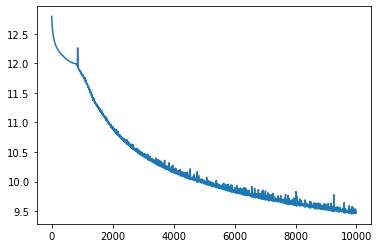

In [16]:
plt.figure()
plt.plot(rpm.loss_tot[10:])
plt.show()


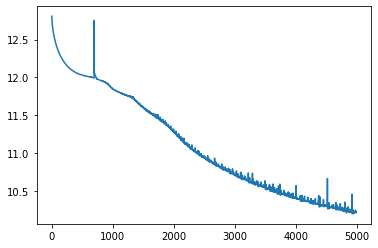

In [13]:
plt.figure()
plt.plot(rpm.loss_tot[10:])
plt.show()


0


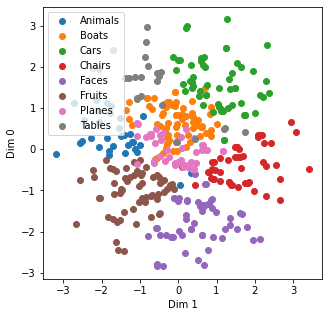

In [17]:
print(0)

#%%

from matplotlib import pyplot as plt




posterior_mean = rpm.dist_marginals.suff_stat_mean[0].squeeze(1).detach().to('cpu')
latent_true = true_latent_train

plot_width = dim_latent - 1
plot_heigh = dim_latent - 1
plt.figure(figsize=(5 * plot_width, 5 * plot_heigh))
for ii in np.arange(dim_latent):
    for jj in np.arange(ii + 1, dim_latent):
        plt.subplot(plot_heigh, plot_width, jj + ii * (dim_latent - 1))
        for class_id in range(len(np.unique(latent_true))):
            mask = latent_true == class_id
            plt.scatter(posterior_mean[mask, jj], posterior_mean[mask, ii], label=label_basic[class_id])
            plt.xlabel('Dim ' + str(jj))
            plt.ylabel('Dim ' + str(ii))

        if ii == 0 and jj == 1:
            plt.legend()


In [35]:
rpm.recognition_auxiliary[0].layers[-1].weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       requires_grad=True)

In [37]:
rpm.recognition_auxiliary[1].param2

0


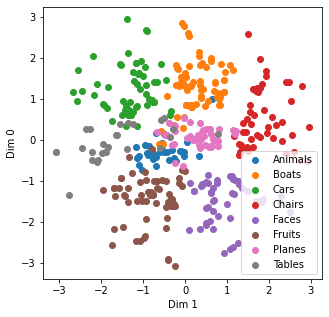

In [8]:




#%%